In [ ]:
}from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drive_path = 'drive/My Drive'

In [ ]:
import os
import numpy as np
import torch
from PIL import Image
import xml.etree.ElementTree as ET

class Take_training_image(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(self.root,"images_giusti"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "images_giusti", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")

        tree = ET.parse(os.path.join(drive_path, 'frames_giusti', 'frame_'+str(idx).zfill(6)+'.xml'))
        root = tree.getroot()

        boxes = []
        label=[]
        area=0;
        for objects in root.findall('object'):
          for objects1 in objects.findall('bndbox'):
            xmin = float(objects1.find('xmin').text)
            ymin = float(objects1.find('ymin').text)
            xmax = float(objects1.find('xmax').text)
            ymax = float(objects1.find('ymax').text)
          can_type = objects.find('name').text
          if(can_type == 'beer'):
            can_type = 1
          else:
            can_type = 2
          boxes.append([xmin, ymin, xmax, ymax])
          label.append(can_type)
          # boxes1 = torch.as_tensor(boxes, dtype=torch.float32)
          
#        print(boxes)
#        print(label)
        
        
        if boxes:
          boxes = torch.as_tensor(boxes, dtype=torch.float32)
          area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # there is only one class
        labels = torch.as_tensor(label, dtype=torch.int64)
        image_id = torch.tensor([idx])
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros(len(label), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.imgs)



dataset = Take_training_image(drive_path)
dataset[12]

(<PIL.Image.Image image mode=RGB size=640x480 at 0x7F854525A750>,
 {'area': tensor([5504.5122]),
  'boxes': tensor([[ 95.9200,  74.8600, 160.8700, 159.6100]]),
  'image_id': tensor([12]),
  'iscrowd': tensor([0]),
  'labels': tensor([1])})

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone.out_channels = 1280
anchor_generator = AnchorGenerator(sizes=((70),),
                                   aspect_ratios=((0.5, 1.0, 1.5),))
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)
model = FasterRCNN(backbone,
                   num_classes=3,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler,
                   min_size=300,
                   max_size=400)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [ ]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(300,), max_size=400, mode='bilinear')
  )
  (backbone): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
 

In [ ]:
%%shell
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 57514, done.
remote: Counting objects: 100% (22983/22983), done.
remote: Compressing objects: 100% (3785/3785), done.
remote: Total 57514 (delta 19550), reused 22087 (delta 18977), pack-reused 34531
Receiving objects: 100% (57514/57514), 109.38 MiB | 29.38 MiB/s, done.
Resolving deltas: 100% (46103/46103), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [ ]:
import transforms as T
from engine import train_one_epoch, evaluate
import utils

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
dataset = Take_training_image(drive_path, get_transform(train=True))
dataset_test = Take_training_image(drive_path, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-200])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-200:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')



# get the model using our helper function
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
from torch.optim.lr_scheduler import StepLR
num_epochs = 3

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [  0/175]  eta: 0:31:13  lr: 0.000034  loss: 0.5714 (0.5714)  loss_classifier: 0.5110 (0.5110)  loss_box_reg: 0.0582 (0.0582)  loss_objectness: 0.0012 (0.0012)  loss_rpn_box_reg: 0.0010 (0.0010)  time: 10.7031  data: 4.5545  max mem: 9266
Epoch: [0]  [ 10/175]  eta: 0:15:16  lr: 0.000321  loss: 0.5714 (0.6185)  loss_classifier: 0.5110 (0.5455)  loss_box_reg: 0.0636 (0.0664)  loss_objectness: 0.0017 (0.0051)  loss_rpn_box_reg: 0.0015 (0.0015)  time: 5.5555  data: 0.4584  max mem: 9587
Epoch: [0]  [ 20/175]  eta: 0:13:48  lr: 0.000608  loss: 0.3869 (0.4571)  loss_classifier: 0.3107 (0.3809)  loss_box_reg: 0.0690 (0.0704)  loss_objectness: 0.0017 (0.0042)  loss_rpn_box_reg: 0.0015 (0.0016)  time: 5.0745  data: 0.0540  max mem: 9587
Epoch: [0]  [ 30/175]  eta: 0:12:44  lr: 0.000895  loss: 0.2151 (0.3617)  loss_classifier: 0.1420 (0.2899)  loss_box_reg: 0.0684 (0.0668)  loss_objectness: 0.0016 (0.0034)  loss_rpn_box_reg: 0.0014 (0.0016)  time: 5.1128  data: 0.0611  max mem: 9587

In [ ]:
class Takeanimage(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(self.root,"images"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        target={}
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

In [ ]:
# pick one image from the test set
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

picture = Take_test_image(drive_path, get_transform(train=False))
for num in range(100):
  img, _ = picture[num]
  tic = time.perf_counter()
  torch.cuda.synchronize()
  t0 = time.time()
  # put the model in evaluation mode
  model.eval()
  model
  with torch.no_grad():
      prediction = model([img.to(device)])
  box = prediction[0].get("boxes")
  scores=prediction[0].get("scores")
  print(scores)
  print(box)
  labels=(prediction[0].get("labels"))
  toc = time.perf_counter()
  torch.cuda.synchronize()
  elapsed_fp = time.time()-t0
  path=os.path.join(drive_path, 'images_test1', 'frame_'+str(num).zfill(6)+'.jpg')
  image = cv2.imread(path)

  for i in range(len(scores)):
    if float(scores[i])>0.30:
      x_m=int(box[i,0].item())
      y_m=int(box[i,1].item())
      x_M=int(box[i,2].item())
      y_M=int(box[i,3].item())

      pt1 = (x_m,y_m)
      print(pt1)
      pt2 = (x_M,y_M)
      print(pt2)
      start_point = (x_m,y_m)
        
      # Ending coordinate, here (125, 80)
      # represents the bottom right corner of rectangle
      end_point = (x_M,y_M)
        
      # Black color in BGR
      color = (0, 0, 200)
        
      # Line thickness of -1 px
      # Thickness of -1 will fill the entire shape
      thickness = 2
        
      # Using cv2.rectangle() method
      # Draw a rectangle of black color of thickness -1 px
      image = cv2.rectangle(image, start_point, end_point, color, thickness)
      if(int(labels[i])==1):
        image = cv2.putText(image, "beer", start_point, 2, 1,(0,255,0), 1);
      if(int(labels[i])==2):
        image = cv2.putText(image, "cola", start_point, 2, 1, (0,255,0), 1);

  len(image)

  cv2_imshow(image)

NameError: ignored

In [ ]:
path=os.path.join(drive_path, 'images_test1', 'frame_'+str(num).zfill(6)+'.jpg')
image = cv2.imread(path)

for i in range(len(scores)):
  if float(scores[i])>0.70:
    x_m=int(box[i,0].item())
    y_m=int(box[i,1].item())
    x_M=int(box[i,2].item())
    y_M=int(box[i,3].item())

    pt1 = (x_m,y_m)
    print(pt1)
    pt2 = (x_M,y_M)
    print(pt2)
    start_point = (x_m,y_m)
      
    # Ending coordinate, here (125, 80)
    # represents the bottom right corner of rectangle
    end_point = (x_M,y_M)
      
    # Black color in BGR
    color = (0, 0, 200)
      
    # Line thickness of -1 px
    # Thickness of -1 will fill the entire shape
    thickness = 2
      
    # Using cv2.rectangle() method
    # Draw a rectangle of black color of thickness -1 px
    image = cv2.rectangle(image, start_point, end_point, color, thickness)
    if(int(labels[i])==1):
      image = cv2.putText(image, "beer", start_point, 2, 1,(0,255,0), 1);
    if(int(labels[i])==2):
      image = cv2.putText(image, "cola", start_point, 2, 1, (0,255,0), 1);

len(image)

cv2_imshow(image)



In [ ]:
# test the quality of the net

In [ ]:
class Take_test_image(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(self.root,"images_test1"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images_test1", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        target={}
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target


#model = torch.load(os.path.join(drive_path,"models/dnn_2.pt"))
#model.load_state_dict(torch.load(os.path.join(drive_path,"models/dnn_2.pt")))

picture = Take_test_image(drive_path, get_transform(train=False))
model.eval()
count=0;
num_images=len(list(sorted(os.listdir(os.path.join(drive_path,"images_test1")))));
for i in range(num_images):
  img, _ = picture[i]
  tree = ET.parse(os.path.join(drive_path,"frames_test1", 'frame_'+str(i).zfill(6)+'.xml'))
  root = tree.getroot()
  label_true=[]
  area=0;
  for objects in root.findall('object'):
    for objects1 in objects.findall('bndbox'):
      can_type = objects.find('name').text
      if(can_type == 'beer'):
        can_type = 1
      else:
        can_type = 2
      label_true.append(can_type)
  with torch.no_grad():
      prediction = model([img.to(device)])

  scores=prediction[0].get("scores")
  labels=(prediction[0].get("labels"))
  #print(scores)
  #print(box)
  #print(elapsed_fp)
  scores=list(scores)
  labels=list(labels)
  m=0;
  for j in range(len(scores)):
    if float(scores[j-m])<0.3:
      del scores[j-m]
      del labels[j-m]
      print(scores)
      m+=1
  labels.sort()
  label_true.sort()
  if labels == label_true:
    count=count+1
print("The network correctly classified  "+str(count/num_images)+"  of the photos")
  
  





AttributeError: ignored

In [ ]:
#trakkerrrr



# import the necessary packages
from scipy.spatial import distance as dist
from collections import OrderedDict
import numpy as np

class CentroidTracker():
	def __init__(self, maxDisappeared=5):
		# initialize the next unique object ID along with two ordered
		# dictionaries used to keep track of mapping a given object
		# ID to its centroid and number of consecutive frames it has
		# been marked as "disappeared", respectively
		self.nextObjectID = 0
		self.objects = OrderedDict()
		self.disappeared = OrderedDict()

		# store the number of maximum consecutive frames a given
		# object is allowed to be marked as "disappeared" until we
		# need to deregister the object from tracking
		self.maxDisappeared = maxDisappeared

	def register(self, centroid):
		# when registering an object we use the next available object
		# ID to store the centroid
		self.objects[self.nextObjectID] = centroid
		self.disappeared[self.nextObjectID] = 0
		self.nextObjectID += 1

	def deregister(self, objectID):
		# to deregister an object ID we delete the object ID from
		# both of our respective dictionaries
		del self.objects[objectID]
		del self.disappeared[objectID]

	def update(self, rects):
		# check to see if the list of input bounding box rectangles
		# is empty
		if len(rects) == 0:
			# loop over any existing tracked objects and mark them
			# as disappeared
			for objectID in list(self.disappeared.keys()):
				self.disappeared[objectID] += 1

				# if we have reached a maximum number of consecutive
				# frames where a given object has been marked as
				# missing, deregister it
				if self.disappeared[objectID] > self.maxDisappeared:
					self.deregister(objectID)

			# return early as there are no centroids or tracking info
			# to update
			return self.objects

		# initialize an array of input centroids for the current frame
		inputCentroids = np.zeros((len(rects), 2), dtype="int")

		# loop over the bounding box rectangles
		for (i, (startX, startY, endX, endY)) in enumerate(rects):
			# use the bounding box coordinates to derive the centroid
			cX = int((startX + endX) / 2.0)
			cY = int((startY + endY) / 2.0)
			inputCentroids[i] = (cX, cY)

		# if we are currently not tracking any objects take the input
		# centroids and register each of them
		if len(self.objects) == 0:
			for i in range(0, len(inputCentroids)):
				self.register(inputCentroids[i])

		# otherwise, are are currently tracking objects so we need to
		# try to match the input centroids to existing object
		# centroids
		else:
			# grab the set of object IDs and corresponding centroids
			objectIDs = list(self.objects.keys())
			objectCentroids = list(self.objects.values())

			# compute the distance between each pair of object
			# centroids and input centroids, respectively -- our
			# goal will be to match an input centroid to an existing
			# object centroid
			D = dist.cdist(np.array(objectCentroids), inputCentroids)

			# in order to perform this matching we must (1) find the
			# smallest value in each row and then (2) sort the row
			# indexes based on their minimum values so that the row
			# with the smallest value as at the *front* of the index
			# list
			rows = D.min(axis=1).argsort()

			# next, we perform a similar process on the columns by
			# finding the smallest value in each column and then
			# sorting using the previously computed row index list
			cols = D.argmin(axis=1)[rows]

			# in order to determine if we need to update, register,
			# or deregister an object we need to keep track of which
			# of the rows and column indexes we have already examined
			usedRows = set()
			usedCols = set()

			# loop over the combination of the (row, column) index
			# tuples
			for (row, col) in zip(rows, cols):
				# if we have already examined either the row or
				# column value before, ignore it
				# val
				if row in usedRows or col in usedCols:
					continue

				# otherwise, grab the object ID for the current row,
				# set its new centroid, and reset the disappeared
				# counter
				objectID = objectIDs[row]
				self.objects[objectID] = inputCentroids[col]
				self.disappeared[objectID] = 0

				# indicate that we have examined each of the row and
				# column indexes, respectively
				usedRows.add(row)
				usedCols.add(col)

			# compute both the row and column index we have NOT yet
			# examined
			unusedRows = set(range(0, D.shape[0])).difference(usedRows)
			unusedCols = set(range(0, D.shape[1])).difference(usedCols)

			# in the event that the number of object centroids is
			# equal or greater than the number of input centroids
			# we need to check and see if some of these objects have
			# potentially disappeared
			if D.shape[0] >= D.shape[1]:
				# loop over the unused row indexes
				for row in unusedRows:
					# grab the object ID for the corresponding row
					# index and increment the disappeared counter
					objectID = objectIDs[row]
					self.disappeared[objectID] += 1

					# check to see if the number of consecutive
					# frames the object has been marked "disappeared"
					# for warrants deregistering the object
					if self.disappeared[objectID] > self.maxDisappeared:
						self.deregister(objectID)

			# otherwise, if the number of input centroids is greater
			# than the number of existing object centroids we need to
			# register each new input centroid as a trackable object
			else:
				for col in unusedCols:
					self.register(inputCentroids[col])

		# return the set of trackable objects
		return self.objects

In [ ]:
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os
import torch
from PIL import Image
import xml.etree.ElementTree as ET
from google.colab.patches import cv2_imshow



class Take_test_image(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(self.root,"images_test"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images_test", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        target={}
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.imgs)

ct = CentroidTracker()
picture = Take_test_image(drive_path, get_transform(train=False))
num_images=len(picture)
model.eval()

for i in range(num_images):

  path=os.path.join(drive_path, 'images_test', 'frame_'+str(i).zfill(6)+'.jpg')
  frame = cv2.imread(path)

  img, _ = picture[i]
  with torch.no_grad():
    detection = model([img.to(device)])

  box1 = detection[0].get("boxes")
  scores = detection[0].get("scores")
  scores=list(scores)
  box1=list(box1)
  rects=[]
	# loop over the detections
  for j in range(len(scores)):
    # filter out weak detections by ensuring the predicted
    # probability is greater than a minimum threshold
    if scores[j] > 0.5:
      # compute the (x, y)-coordinates of the bounding box for
			# the object, then update the bounding box rectangles list
      
      box = np.array(box1[j].cpu())

      rects.append(box.astype("int"))
      
			# draw a bounding box surrounding the object so we can
			# visualize it
      (startX, startY, endX, endY) = box.astype("int")
      cv2.rectangle(frame, (startX, startY), (endX, endY),(0, 255, 0), 2)
	# update our centroid tracker using the computed set of bounding
	# box rectangles
  objects = ct.update(rects)
	# loop over the tracked objects
  for (objectID, centroid) in objects.items():
   	# draw both the ID of the object and the centroid of the
		# object on the output frame
    text = "ID {}".format(objectID)
    cv2.putText(frame, text, (centroid[0] - 10, centroid[1] - 10),
    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    cv2.circle(frame, (centroid[0], centroid[1]), 4, (0, 255, 0), -1)

	# show the output frame
  cv2_imshow(frame)
  key = cv2.waitKey(1) & 0xFF

	# if the `q` key was pressed, break from the loop
  if key == ord("q"):
   break

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

In [ ]:
torch.save(model, drive_path+'/models')

In [ ]:
model = torch.load(drive_path+'/models')

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
%%shell
git clone https://github.com/ultralytics/yolov5
pip install -r yolov5/requirements.txt

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [ ]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)


In [ ]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):

    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    tree = ET.parse(os.path.join(xml_file))
    root = tree.getroot()

    boxes = []
    label=[]
    for objects in root.findall('object'):
      for objects1 in objects.findall('bndbox'):
        bbox = {}
        bbox["class"] = objects.find('name').text
        bbox["xmin"]= float(objects1.find('xmin').text)
        bbox["ymin"]= float(objects1.find('ymin').text)
        bbox["xmax"]= float(objects1.find('xmax').text)
        bbox["ymax"]= float(objects1.find('ymax').text)
        info_dict['bboxes'].append(bbox)
    info_dict['image_size'] = tuple((640,480,3))
    info_dict['filename'] =xml_file[-16:]
    #print(xml_file[-16:])

    return info_dict

In [ ]:
idx=5;
print(extract_info_from_xml(os.path.join(drive_path, 'frames_giusti', 'frame_'+str(idx).zfill(6)+'.xml')))

{'bboxes': [{'class': 'beer', 'xmin': 96.01, 'ymin': 74.7, 'xmax': 160.96, 'ymax': 159.45}], 'image_size': (640, 480, 3), 'filename': 'frame_000005.xml'}


In [ ]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"beer": 0,
                           "coke": 1,
                            "cola": 1}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join(drive_path, "frames_yolo", info_dict["filename"].replace("xml", "txt"))
    
    # Save the annotation to disk
    #file= open(save_file_name, "w")
    #file.write("\n".join(print_buffer))
    print("\n".join(print_buffer), file= open(save_file_name, "w") )
    #file.close()

In [ ]:
# Get the annotations
annotations = [os.path.join(drive_path, 'frames_giusti', x) for x in os.listdir(os.path.join(drive_path, 'frames_giusti')) if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join(drive_path, "frames_yolo", x) for x in os.listdir(os.path.join(drive_path, "frames_yolo")) if x[-3:] == "txt"]

100%|██████████| 1608/1608 [00:14<00:00, 111.27it/s]


drive/My Drive/frames_yolo/frame_000664.txt
drive/My Drive/images_giusti/frame_000664.jpg


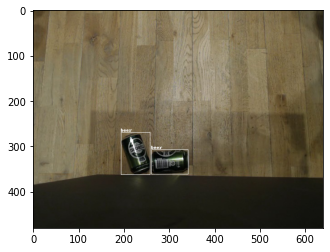

In [ ]:
random.seed(7)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
print(annotation_file)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
#image_file=os.path.join(drive_path, 'images_test1', 'frame_'+str(num).zfill(6)+'.jpg')
#image_file = os.path.join(drive_path, 'images_giusti', (annotation_file.replace(drive_path,"").replace("/frames_yolov5","").replace("txt", "jpg")))
image_file = os.path.join(drive_path, 'images_giusti',annotation_file[-16:].replace("txt","jpg"))
print(image_file)
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [ ]:
# Read images and annotations
images = [os.path.join(drive_path, 'images_giusti', x) for x in os.listdir(os.path.join(drive_path, 'images_giusti'))][:-1]
annotations = [os.path.join(drive_path, "frames_yolo", x) for x in os.listdir(os.path.join(drive_path,"frames_yolo")) if x[-3:] == "txt"]

print(len(images[:-1]))
print(len(annotations))

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

1607
1608


In [ ]:
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images,os.path.join(drive_path, 'yolo',"images","train"))
move_files_to_folder(val_images, os.path.join(drive_path, 'yolo',"images","val"))
move_files_to_folder(test_images, os.path.join(drive_path, 'yolo',"images","test"))
move_files_to_folder(train_annotations, os.path.join(drive_path, 'yolo',"labels","train"))
move_files_to_folder(val_annotations, os.path.join(drive_path, 'yolo',"labels","val"))
move_files_to_folder(test_annotations, os.path.join(drive_path, 'yolo',"labels","test"))

In [ ]:
%cd ..



/content/yolov5


In [ ]:
!python train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch.yaml --batch 32 --epochs 100 --data coco128.yaml --weights yolov5s.pt --workers 24 --name yolo_road_det

train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=coco128.yaml, hyp=hyp.scratch.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=24, project=runs/train, name=yolo_road_det, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (5/5), done.
remote: Total 6 (delta 5), reused 5 (delta 5), pack-reused 1
Unpacking objects: 100% (6/6), done.
From https://github.com/ultralytics/yolov5
   7c6bae0..fcd180d  master     -> origin/master
github: ⚠️ YOLOv5 is out of date by 1 commit. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.0-109-g7c6bae0 tor